In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

`Deactivating JEDI for autocomplete to work`

In [2]:
%config Completer.use_jedi = False

# Feature Engineering - Describing, preprocessing, cleaning

`Reading train.csv`

In [3]:
train_data = pd.read_csv("../input/fake-news/train.csv")

`Generating descriptive statistics about the dataframe`

In [4]:
train_data.describe()

,id,label
count,20800.000000,20800.000000
mean,10399.500000,0.500625
std,6004.587135,0.500012
min,0.000000,0.000000
25%,5199.750000,0.000000
50%,10399.500000,1.000000
75%,15599.250000,1.000000
max,20799.000000,1.000000


`Fetching any null values in the dataframe, and summing them up!`

In [5]:
train_data.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

`Repeating the above steps for test.csv`

In [6]:
test_data = pd.read_csv("../input/fake-news/test.csv")

In [7]:
test_data.describe()

,id
count,5200.000000
mean,23399.500000
std,1501.255031
min,20800.000000
25%,22099.750000
50%,23399.500000
75%,24699.250000
max,25999.000000


In [8]:
test_data.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


`Checking the number of unique row count for "Label" column`

In [11]:
train_data['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


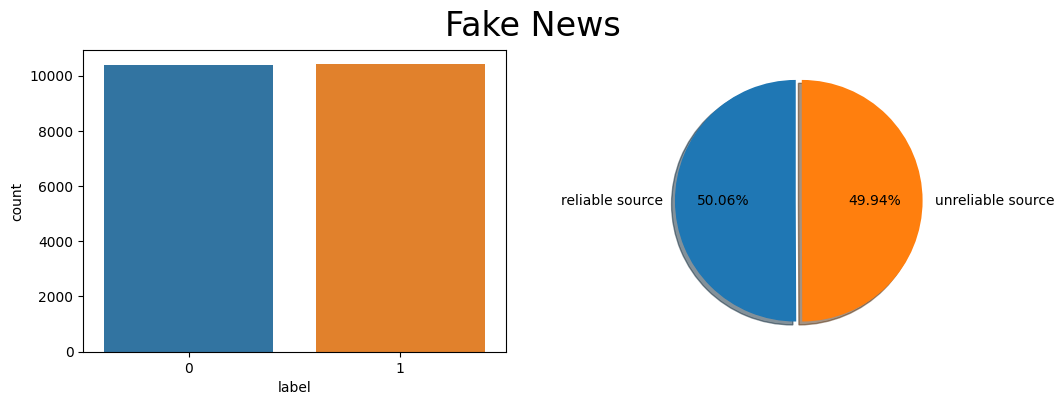

In [12]:
# Creating a figure adding two columns as we've {0,1} as labels signifying reliable/unreliable resources
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4), dpi=100)

# Displaying both observations in a bar chart format
sns.countplot(train_data['label'], ax=axes[0])

# Create a Pie-chart
## 'autopct' enables you to display the percent value using Python string formatting.
## 'explode' created a divider space to separate each pizza pieces
## 'startangle' signifies the tilt for the explode.
axes[1].pie(train_data['label'].value_counts(),labels=['reliable source', 'unreliable source'],autopct='%1.2f%%',shadow=True,explode=(0.05, 0),startangle=90)

# Adding a centered Title to the graphs
fig.suptitle('Fake News', fontsize=24)
plt.show()

# # Managing Null values

`Since there are Null values in the categorical columns, we will fill the null values with the empty strings`

In [13]:
train_data = train_data.fillna('')

In [14]:
test_data = test_data.fillna('')

`Merging two columns {title,author} for predicting fake/real news`

In [15]:
train_data['total'] = train_data['title'] + ' ' + train_data['author']

In [16]:
test_data['total'] = test_data['title'] + ' ' + test_data['author']

<AxesSubplot:xlabel='Author'>

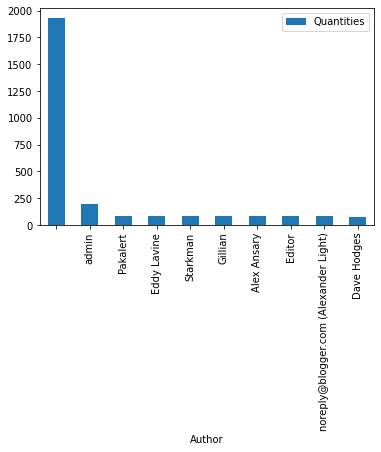

In [17]:
unreliable_author = pd.DataFrame({'Author':train_data[train_data['label']==1]['author'].value_counts().head(10).index,'Quantities':train_data[train_data['label']==1]['author'].value_counts().head(10)})

unreliable_author.plot(kind='bar',x='Author',y='Quantities')

<AxesSubplot:xlabel='Author'>

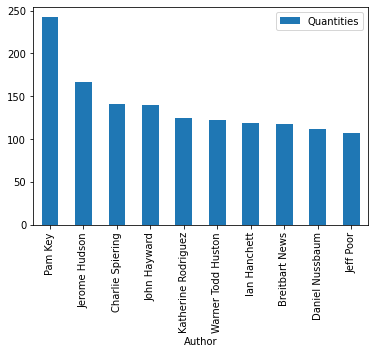

In [18]:
reliable_author = pd.DataFrame({'Author':train_data[train_data['label']==0]['author'].value_counts().head(10).index,'Quantities':train_data[train_data['label']==0]['author'].value_counts().head(10)})

reliable_author.plot(kind='bar',x='Author',y='Quantities')

``Dropping the sample {label} column before training

In [19]:
X = train_data.drop('label',axis=1)
y = train_data['label']

In [20]:
X.shape

(20800, 5)

In [21]:
y.shape

(20800,)

# # Building Vocab

In [22]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
vocab = 8000
news = X.copy()
news_test = test_data.copy()

`Going to use Stemming technique to map each word to their original root form`

In [24]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []

In [25]:
for i in range(len(news)):
    # removing emojis, punctuations, urls if present
    review = re.sub('[^a-zA-Z]',' ', news['total'][i])
    # keeping all the text in a lowercase
    review = review.lower()
    # Tokenizing the text in a list
    review = review.split()
    # removing stopwords and applying word stemming.
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    # Creating back to a string
    review = ' '.join(review)
    corpus.append(review)

corpus_test = []
for i in range(len(news_test)):
    # removing emojis, punctuations, urls if present
    review = re.sub('[^a-zA-Z]',' ',news_test['total'][i])
    # keeping all the text in a lowercase
    review = review.lower()
    # Tokenizing the text in a list
    review = review.split()
    # removing stopwords and applying word stemming.
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    # Creating back to a string
    review = ' '.join(review)
    corpus_test.append(review)

`Applying One-Hot Encoding to the words and vocab.`

In [26]:
from tensorflow.keras.preprocessing.text import one_hot

In [27]:
onehot = [one_hot(words,vocab) for words in corpus]
onehot_test = [one_hot(words,vocab) for words in corpus_test]

`Padding each sentence to turn them into equal length`

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [29]:
embedded_docs = pad_sequences(onehot, padding = 'pre', maxlen = 25)
embedded_docs_test = pad_sequences(onehot_test, padding = 'pre', maxlen = 25)

# Training the Model

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout

`Using LSTM`

In [31]:
model = Sequential()
model.add(Embedding(vocab,40,input_length=25))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam'),metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            320000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

`Converting the embeddings to a numpy array`

In [32]:
X_final = np.array(embedded_docs)
y_final = np.array(y)
test_final = np.array(embedded_docs_test)
X_final.shape,y_final.shape,test_final.shape

((20800, 25), (20800,), (5200, 25))

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='auto')

In [34]:
history = model.fit(X_final, y_final, epochs=30, batch_size=32, callbacks=[callback])

Epoch 1/30
650/650 [==============================] - 6s 6ms/step - loss: 0.2550 - accuracy: 0.8866
Epoch 2/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0113 - accuracy: 0.9970
Epoch 3/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0055 - accuracy: 0.9983
Epoch 4/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 5/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 6/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0013 - accuracy: 0.9995
Epoch 7/30
650/650 [==============================] - 4s 6ms/step - loss: 9.7165e-04 - accuracy: 0.9997
Epoch 8/30
650/650 [==============================] - 5s 7ms/step - loss: 4.0585e-04 - accuracy: 1.0000
Epoch 9/30
650/650 [==============================] - 4s 6ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 10/30
650/650 [==============================] - 4s 6ms/step - loss: 4.2033e-04 - accu

In [35]:
len(history.history['loss'])

14

In [36]:
model.save('News Reliability.h5')

Text(0.5, 0, 'epoch')

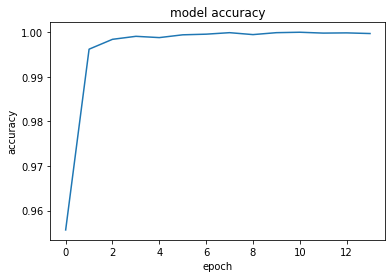

In [37]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

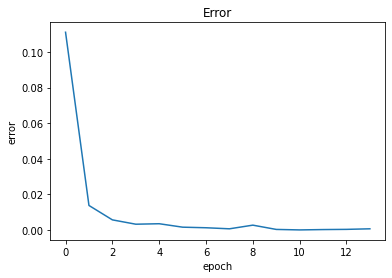

In [38]:
plt.plot(history.history['loss'])
plt.title('Error')
plt.ylabel('error')
plt.xlabel('epoch')

In [39]:
y_pred = model.predict_classes(test_final)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [41]:
result = pd.DataFrame()
result['id']=test_data['id']
result['label'] = y_pred
result.to_csv('result.csv',index=False)